In [42]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import astropy.coordinates as coords
import astropy.units as u
from astropy.nddata import Cutout2D
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from regions import Regions
import yaml
import warnings

In [15]:
chan_range = {16: [3486.1, 4278.1], #[128, 268],
              31: [3849.6, 4444.7], #[270, 375],
              91: [7508.3, 6613.0]} #[595, 750]}
distances = {16: 49.0,
             31: 53.0,
             91: 92.0}


In [43]:
def jy_to_cm2(data,hdr):
    '''
    Convert moment 0 map into column density
    Parameters
    ----------
    data: HDU data array
    hdr: HDU header
    '''
    bunit = hdr['BUNIT']
    if bunit.lower() in ['jy/beam.m/s', 'jy/beam*m/s']:
        fac = 1.249e21
    elif bunit.lower().replace(' ','') in ['jy/beam.km/s', 'jy/beam*km/s', 'beam-1jykms-1']:
        fac = 1.249e24
    else:
        fac = 1.249e24
        print('check moment 0 units, considering "Jy/beam.km/s" but could be wrong')
    bmaj, bmin = hdr['BMAJ'] * 3600., hdr['BMIN'] * 3600.
    beam_area = bmaj * bmin * np.pi / (4.0 * np.log(2.0))
    nhi = fac * data / beam_area
    return nhi

def totflux(data, hdr):
    '''Calculate total flux from an HDU
    Parameters
    ----------
    data: HDU data array
    hdr: HDU header
    '''
    cell_size = abs(hdr['CDELT1'])
    cell_area = cell_size * cell_size
    bmaj, bmin = hdr['BMAJ'], hdr['BMIN']
    beam_area = bmaj * bmin * np.pi / (4.0 * np.log(2.0) * cell_area)
    box = data.copy()
    sdv = np.nansum(box) / beam_area ### conversion from Jy/beam.km/s to Jy.km/s
    bunit = hdr['BUNIT']
    if bunit.lower().replace(' ','') in ['jy/beam.m/s', 'jy/beam*m/s', 'beam-1jyms-1']: ### convert from Jy/beam.m/s to Jy/beam.km/s
        sdv *= 1e-3
    return sdv

def himass(f, D):
    '''Calculate HI mass from flux f (Jy.km/s) and distance D (Mpc)
    Parameters
    ----------
    f: flux in Jy.km/s
    D: distance in Mpc
    '''
    m = 2.36e5 * D**2 * f
    return np.log10(m)

In [67]:
 def plot_moment_maps(hcg):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    mydir = 'slicerastro_output/'
    colors = ['w', 'b', 'cyan', 'magenta', 'yellow']
    with open('ids_to_galnames.yml') as fp:
        ids_to_galnames = yaml.safe_load(fp)
    id_to_galname = ids_to_galnames[f'HCG {hcg}']
    opt_d, opt_h = fits.getdata(f'legacy_images/HCG{hcg}_grz.fits', header=True)
    cube = SpectralCube.read(f'hcg_cubes/hcg{hcg}_cropped.fits')
    cube_kms = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1420405752*u.Hz)
    mask_array = fits.getdata(f'slicerastro_output/hcg{hcg}_all_mask.fits')
    raw_mask_array = fits.getdata(f'hcg_cubes/hcg{hcg}_mask_cropped.fits')
    if len(raw_mask_array.shape) > 3:
        raw_mask_array = raw_mask_array[0]
    reg = Regions.read(f'hcg_cubes/box_hcg{hcg}.reg', format='crtf')
    if len(reg) == 1:
        ccoo = reg[0].center
        width, height = reg[0].width, reg[0].height

    cutout = Cutout2D(opt_d[0], position=ccoo, size=(height,width), wcs=WCS(opt_h).celestial)
    r, wcs = cutout.data, cutout.wcs
    vmin=np.nanmedian(r)-0.05*np.nanstd(r)
    vmax=np.nanmedian(r)+0.1*np.nanstd(r)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection=wcs.celestial)
    ax.imshow(r, vmin=vmin, vmax=vmax, cmap='gray_r')

    all_hi_mask = raw_mask_array > 0.
    all_hi = cube_kms.with_mask(all_hi_mask)
    igm_mask = mask_array == 0.
    igm_cube = all_hi.with_mask(igm_mask)
    igm_m0 = igm_cube.moment(order=0)
    levels = [6.6e18 * 2**x for x in range(15)]
    igm_nhi = jy_to_cm2(igm_m0, igm_m0.hdu.header)
    igm_nhi[np.isnan(igm_nhi)] == 0.
    ax.contour(igm_nhi, levels=levels, colors='k', linewidths=0.7, transform=ax.get_transform(igm_m0.wcs))
    mhi_tot = 0.
    for key in id_to_galname.keys():
        mask = mask_array == float(key)
        masked_cube = cube_kms.with_mask(mask)
        m0 = masked_cube.moment(order=0)
        galname = id_to_galname[key].lower().replace(' ','')
        m0.hdu.writeto(f'hcg_cubes/hcg{hcg}_mom0_{galname}.fits', overwrite=True)
        m0_data = m0.hdu.data
        flux = totflux(m0_data, m0.hdu.header)
        mhi = himass(flux, distances[hcg])
        mhi_tot += 10**mhi
        nhi_data = jy_to_cm2(m0_data, m0.hdu.header)
        nhi_data[np.isnan(nhi_data)] = 0
        ax.contour(nhi_data, levels=levels, colors=colors[int(key)-1], linewidths=1, transform=ax.get_transform(m0.wcs))
        print(f'{galname.upper()}: {mhi:.1f}')
    print(f'Total: {np.log10(mhi_tot): .2f}')
    ax.coords[0].set_axislabel('RA (J2000)'); ax.coords[1].set_axislabel('Dec (J2000)')
    plt.savefig(f'hcg_cubes/hcg{hcg}_core_members.pdf')
    plt.show()

In [111]:
 def plot_moment_maps_hires(hcg):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    mydir = 'slicerastro_output/'
    colors = ['w', 'b', 'cyan', 'magenta', 'yellow']
    with open('ids_to_galnames.yml') as fp:
        ids_to_galnames = yaml.safe_load(fp)
    id_to_galname = ids_to_galnames[f'HCG {hcg}']
    opt_d, opt_h = fits.getdata(f'legacy_images/HCG{hcg}_grz.fits', header=True)
    cube = SpectralCube.read(f'hcg_cubes/hcg{hcg}_cropped_15as.fits')
    cube_kms = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1420405752*u.Hz)
    mask_array = fits.getdata(f'slicerastro_output/hcg{hcg}_all_15as_mask.fits')
    raw_mask_array = fits.getdata(f'hcg_cubes/hcg{hcg}_mask_cropped_15as.fits')
    if len(raw_mask_array.shape) > 3:
        raw_mask_array = raw_mask_array[0]
    reg = Regions.read(f'hcg_cubes/box_hcg{hcg}.reg', format='crtf')
    if len(reg) == 1:
        ccoo = reg[0].center
        width, height = reg[0].width, reg[0].height

    cutout = Cutout2D(opt_d[0], position=ccoo, size=(height,width), wcs=WCS(opt_h).celestial)
    r, wcs = cutout.data, cutout.wcs
    vmin=np.nanmedian(r)-0.05*np.nanstd(r)
    vmax=np.nanmedian(r)+0.1*np.nanstd(r)
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection=wcs.celestial)
    ax.imshow(r, vmin=vmin, vmax=vmax, cmap='gray_r')

    all_hi_mask = raw_mask_array > 0.
    all_hi = cube_kms.with_mask(all_hi_mask)
    # igm_mask = mask_array == 0.
    # igm_cube = all_hi.with_mask(igm_mask)
    all_hi_m0 = all_hi.moment(order=0)
    # igm_m0 = igm_cube.moment(order=0)
    levels = [6.6e18 * 2**x for x in range(15)]
    all_hi_nhi = jy_to_cm2(all_hi_m0, all_hi_m0.hdu.header)
    # igm_nhi = jy_to_cm2(igm_m0, igm_m0.hdu.header)
    all_hi_nhi[np.isnan(all_hi_nhi)] == 0.
    ax.contour(all_hi_nhi, levels=levels, colors='k', linewidths=0.7, transform=ax.get_transform(all_hi_m0.wcs))
    mhi_tot = 0.
    for key in id_to_galname.keys():
        mask = mask_array == float(key)
        masked_cube = cube_kms.with_mask(mask)
        m0 = masked_cube.moment(order=0)
        galname = id_to_galname[key].lower().replace(' ','')
        m0.hdu.writeto(f'hcg_cubes/hcg{hcg}_mom0_{galname}.fits', overwrite=True)
        m0_data = m0.hdu.data
        flux = totflux(m0_data, m0.hdu.header)
        mhi = himass(flux, distances[hcg])
        mhi_tot += 10**mhi
        nhi_data = jy_to_cm2(m0_data, m0.hdu.header)
        nhi_data[np.isnan(nhi_data)] = 0
        ax.contour(nhi_data, levels=levels, colors=colors[int(key)-1], linewidths=1, transform=ax.get_transform(m0.wcs))
        print(f'{galname.upper()}: {mhi:.1f}')
    print(f'Total: {np.log10(mhi_tot): .2f}')
    ax.coords[0].set_axislabel('RA (J2000)'); ax.coords[1].set_axislabel('Dec (J2000)')
    ax.set_xlim((0.5*r.shape[1]-0.25*r.shape[1]), (0.5*r.shape[1]+0.25*r.shape[1]))
    ax.set_ylim((0.5*r.shape[0]-0.25*r.shape[0]), (0.5*r.shape[0]+0.25*r.shape[0]))
    plt.savefig(f'hcg_cubes/hcg{hcg}_core_members_15as.pdf')
    plt.show()

HCG31Q: 8.7
HCG31B: 9.0
HCG31C: 8.9
HCG31A: 8.7
HCG31G: 8.8
Total:  9.54


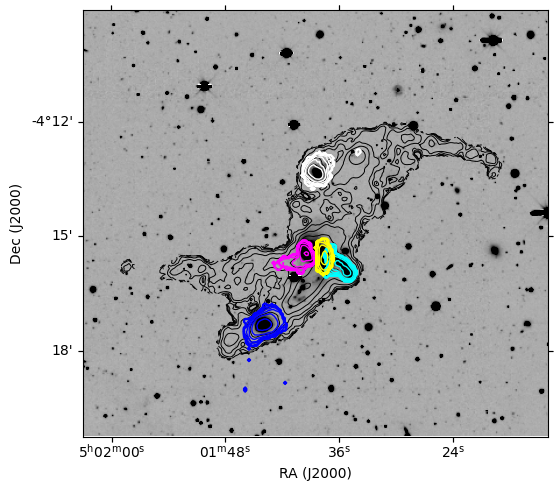

In [112]:
plot_moment_maps_hires(31)

In [37]:
masked_cube_kms = masked_cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1420405752*u.Hz)
moment_0 = masked_cube_kms.moment(order=0)

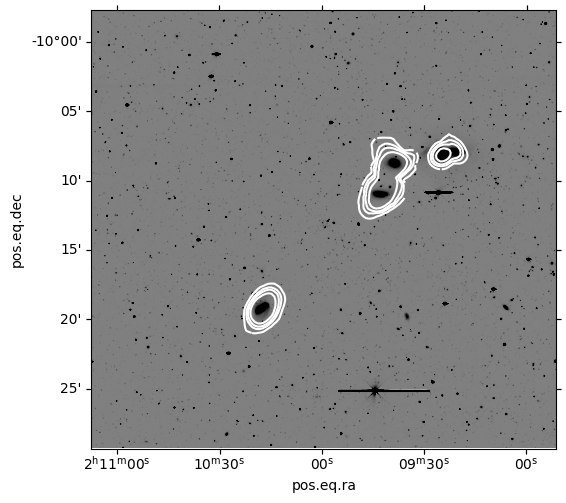

In [41]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection=wcs.celestial)
ax.imshow(r, vmin=vmin, vmax=vmax, cmap='gray_r')
ax.contour(moment_0, levels=[0.1, 0.3, 0.5, 0.9], colors='w', transform=ax.get_transform(moment_0.wcs));

In [19]:
cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'VOPT-F2W'  
CRVAL : 32.38875  -10.1630555556  5005843.30507  
CRPIX : 115.0  99.0  -127.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00333333333333  0.00333333333333  -5699.08197144  
NAXIS : 165  159  141

In [27]:
mask_data.shape, data.shape

((141, 159, 165), (141, 159, 165))